In [20]:
#HF Example

import torch
from transformers import pipeline

pipe = pipeline(
    task="image-classification",
    model="facebook/dinov2-small-imagenet1k-1-layer",
    dtype=torch.float16,
    device="cuda"
)

pipe("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

Device set to use cuda


[{'label': 'tiger, Panthera tigris', 'score': 0.24335609376430511},
 {'label': 'tiger cat', 'score': 0.24146227538585663},
 {'label': 'lynx, catamount', 'score': 0.16084855794906616},
 {'label': 'marmot', 'score': 0.043973542749881744},
 {'label': 'tabby, tabby cat', 'score': 0.03293466567993164}]

In [21]:


from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
cls_embedding = last_hidden_states[:, 0, :]



In [22]:
print(cls_embedding.size())

torch.Size([1, 768])


In [23]:
import hdf5
file=hdf5.open_HDF5("downloaded_embeddings.h5")
vectors=file["vectors"]
vectors=vectors[:] #load into a np array
labels=file["coordinates"]
labels=labels[:]
print(vectors)
print(labels)
file.close()

[[ 0.95240444  1.3240675   0.28314427 ... -0.40695077 -0.12938523
   0.65251255]
 [ 0.73756576  1.2255933   0.01971832 ... -2.2677386   0.3768237
   1.4319218 ]
 [ 0.8730782   1.568318    0.21059269 ...  1.7526027  -1.3327127
   1.7590166 ]
 ...
 [ 2.8841746  -2.7090735  -1.8563217  ...  3.5333478  -1.8200037
  -1.7979321 ]
 [ 0.7231116  -0.3009514  -2.2173426  ... -2.9620824   1.0859857
   0.02212841]
 [ 0.88997984  0.62839216 -1.7182935  ... -2.0426896   2.6787934
   1.5962486 ]]
[[38.01888  -7.86417 ]
 [42.89792  -5.537902]
 [43.729904  3.313452]
 ...
 [47.63359  12.09996 ]
 [48.365     6.681111]
 [50.73414   9.120029]]


In [24]:
import h5py
import hdf5
#Size of hp5
print("agah")
path="/home/adam/source/CLIP/full_dataset_embeddings.h5"
hdf5.get_size(path)




agah
coordinates: shape=(3167055, 2), dtype=float32
vectors: shape=(3167055, 768), dtype=float32


/home/adam/anaconda3/envs/bioCLIP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing similarities: 100%|██████████| 50000/50000 [01:32<00:00, 539.30it/s]


Mean: tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
Std: tensor(0.0941, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.0942, device='cuda:0', grad_fn=<SqrtBackward0>)


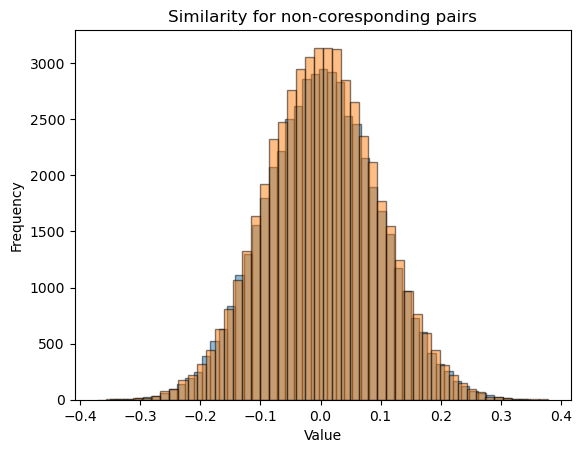

In [ ]:
#Test the clip model


import utils
import nn_classes
import importlib
import torch.nn as nn
import torch
importlib.reload(utils)
importlib.reload(nn_classes)
from tqdm import tqdm
torch.cuda.empty_cache()

device="cuda"
data_path="embeddings_data_and_dictionaries/bioCLIP_full_dataset_embeddings.h5"
dim_fourier_encoding=512 #multiple of 4!!
dim_hidden=1024
dim_emb=256 #this one is actually shared with img embeddings
pos_encoder= nn_classes.RFF_MLPs(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb,M=8,sigma_min=2,sigma_max=256, number_layers=4)
#pos_encoder=utils.RFF_MLPs( original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=512,M=8,sigma_min=1,sigma_max=256).to(device)

model= nn_classes.DoubleNetwork_V2(pos_encoder,dim_hidden=768,dim_output=dim_emb).to(device)
model.load_state_dict(torch.load("tests_checkpoint_1/model.pt", weights_only=True))
model.eval()

nbr_iter=50000
mean_sim, mean_asim, std_sim, std_asim = utils.test_similarity(data_path,model, nbr_samples=2,device="cuda",nbr_iter=nbr_iter,plot_sims=True)
print("Mean:", mean_sim, mean_asim)
print("Std:", std_sim, std_asim)
#for the whole test  set:
#Mean: tensor(0.1810, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0827, device='cuda:0', grad_fn=<DivBackward0>)
#Std: tensor(0.0645, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.0726, device='cuda:0', grad_fn=<SqrtBackward0>)

DINO encoder: 
Mean: tensor(0.1963, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0707, device='cuda:0', grad_fn=<DivBackward0>)
Std: tensor(0.0655, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.0752, device='cuda:0', grad_fn=<SqrtBackward0>)

Computing similarities: 100%|██████████| 100000/100000 [01:57<00:00, 850.59it/s]


Mean: tensor(0.0222, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>)
Std: tensor(0.1133, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1136, device='cuda:0', grad_fn=<SqrtBackward0>)


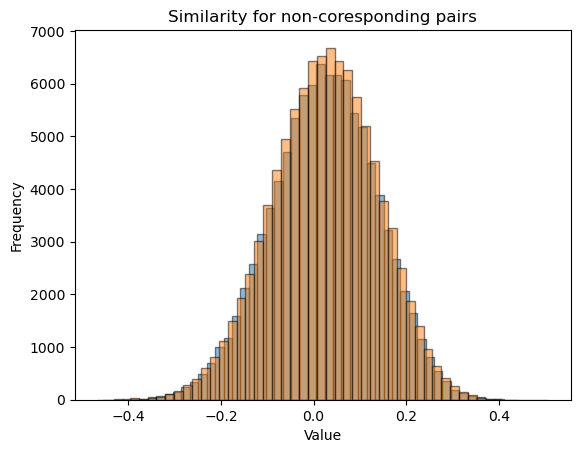

In [ ]:
import utils
import nn_classes
import hdf5
import importlib
import torch
importlib.reload(utils)
device="cuda"
data_path="embeddings_data_and_dictionaries/bioCLIP_full_dataset_embeddings.h5"
#file=hdf5.open_HDF5(data_path)
#file.close()
#Bioclip tests
dim_fourier_encoding=128 #multiple of 4!!
dim_hidden=256
dim_emb=128 #this one is actually shared with img embeddings
pos_encoder= nn_classes.RFF_MLPs(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb,M=4,sigma_min=2,sigma_max=256, number_layers=2)
#pos_encoder=utils.RFF_MLPs( original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=512,M=8,sigma_min=1,sigma_max=256).to(device)

model= nn_classes.DoubleNetwork_V2(pos_encoder,dim_hidden=768,dim_output=dim_emb).to(device)
#model=model.load_state_dict(torch.load("first_run_bioCLIP_encoder_checkpoint_1/model.pt", weights_only=True))
model.load_state_dict(
    torch.load("RFF_small_weekend_run/model.pt", weights_only=True)
)

model.eval()

nbr_iter=100000
mean_sim, mean_asim, std_sim, std_asim = utils.test_similarity(data_path,model, nbr_samples=2,device="cuda",nbr_iter=nbr_iter,plot_sims=True)
print("Mean:", mean_sim, mean_asim)
print("Std:", std_sim, std_asim)

Bioclip (simple architechture):
Mean: tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0632, device='cuda:0', grad_fn=<DivBackward0>)
Std: tensor(0.0844, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1299, device='cuda:0', grad_fn=<SqrtBackward0>)

In [26]:
#Number of occurences in Switwerland

import pandas as pd

# Replace 'data.tsv' with the path to your file
file_path = '/home/adam/source/CLIP/data_plantnet_obsevations/occurrence.txt'

# Load the TSV file
df = pd.read_csv(file_path, sep='\t', low_memory=False)

# Check the column names for country info
print(df.columns)

# Filter rows where the country is Switzerland
switzerland_data = df[df['countryCode'] == 'CH']

# Count the number of rows
num_datapoints = len(switzerland_data)

print(f"Number of datapoints in Switzerland: {num_datapoints}")

# Filter rows where the country is Switzerland
france_data = df[df['countryCode'] == 'FR']

# Count the number of rows
num_datapoints = len(france_data)

print(f"Number of datapoints in France: {num_datapoints}")


Index(['gbifID', 'accessRights', 'bibliographicCitation', 'language',
       'license', 'modified', 'publisher', 'references', 'rightsHolder',
       'type',
       ...
       'publishedByGbifRegion', 'level0Gid', 'level0Name', 'level1Gid',
       'level1Name', 'level2Gid', 'level2Name', 'level3Gid', 'level3Name',
       'iucnRedListCategory'],
      dtype='object', length=226)
Number of datapoints in Switzerland: 74963
Number of datapoints in France: 884128


densité de points en suisse: 
74963/41 285 km2=1.81

France: 884128/632 702 km2=1.39
We good

In [27]:
# Replace 'data.tsv' with the path to your file
file_path =  '/home/adam/source/CLIP/data_plantnet_obsevations/occurrence.txt'

# Load the TSV file
df = pd.read_csv(file_path, sep='\t', low_memory=False)

# Count datapoints per country
country_counts = df['countryCode'].value_counts()

# Display results
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Avoid line wrapping
pd.set_option('display.max_colwidth', None)  # Full column width
print(country_counts)


countryCode
FR    884128
ES    253748
DE    237009
IT    199536
GB    132793
US    125428
NL    104618
CH     74963
CZ     61113
BE     59173
AT     44565
PL     36438
CA     29717
PT     28453
RU     22644
HU     21479
SK     16528
BR     15615
GR     14699
KE     14308
SE     13236
HR     11800
TR     11083
IN     11004
IE      9793
DK      9445
NO      9042
UA      8886
RO      8085
FI      8053
SI      7181
RE      6587
AR      6290
AU      4955
BG      4680
CL      3733
MX      3678
RS      3487
CR      3089
MA      3013
DZ      2681
CO      2623
GP      2530
LU      2396
ZA      2232
EE      2055
MQ      1981
BA      1895
ID      1850
JP      1669
IL      1645
IR      1634
BY      1602
ME      1554
LV      1549
LT      1506
NC      1490
IS      1312
TH      1302
MG      1248
CG      1143
NZ      1088
CY      1075
GE       996
MT       969
DO       946
AL       825
PE       783
GF       741
UY       719
MY       712
VN       676
AD       672
CN       668
TN       656
EC       651


Section dedicated to get the proper data and fit linear model from both covariates and embeddings, to compare.

In [2]:
#Get the Model
import utils
import nn_classes
import importlib
import torch.nn as nn
import torch
importlib.reload(utils)
importlib.reload(nn_classes)
from tqdm import tqdm
device="cuda"
data_path="embeddings_data_and_dictionaries/bioCLIP_full_dataset_embeddings.h5"
dim_fourier_encoding=512 #multiple of 4!!
dim_hidden=1024
dim_emb=256 #this one is actually shared with img embeddings
pos_encoder= nn_classes.RFF_MLPs(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb,M=8,sigma_min=2,sigma_max=256, number_layers=4)

model= nn_classes.DoubleNetwork_V2(pos_encoder,dim_hidden=768,dim_output=dim_emb).to(device)
model.load_state_dict(torch.load("tests_checkpoint_1/model.pt", weights_only=True))
model.eval()

################## MLP Models
def train_one_MLP(model, X, y, epochs=200, batch_size=250, lr=1e-4):
    model=model.to("cuda")
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)

    ds = TensorDataset(X_t, y_t)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    loss_fn = nn.BCEWithLogitsLoss().to("cuda")
    #loss_fn = deepmaxent_loss().to("cuda")

    pbar=range(epochs)
    for _ in tqdm(pbar):
        for xb, yb in dl:
            xb = xb.to("cuda")
            yb = yb.to("cuda")
            pred = model(xb)
            loss = loss_fn(pred, yb).to("cuda")
            optim.zero_grad()
            loss.backward()
            optim.step()
    model=model.cpu()
    return model

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# -------- Minimal MLP architecture --------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden=[256, 256], out_dim=30):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, out_dim))  # linear output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x=self.net(x)
        return x

'''
train_defaults:
  lr: 2.0e-4
  epochs: 200
  weight_decay: 3.0e-4
  bs: 250
  hidden_size: 250
  hidden_layers: 2
  print_every: 100
'''

class deepmaxent_loss(nn.Module):
    def __init__(self):
        super(deepmaxent_loss, self).__init__()
    def forward(self, input, target):
        loss = -((target)*(input.log_softmax(0))).mean(0).mean()
        return loss
    


IndentationError: expected an indented block after function definition on line 270 (utils.py, line 272)

In [ ]:
#Fit model

from sklearn.linear_model import PoissonRegressor
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import utils
import importlib
import torch
from sklearn.preprocessing import StandardScaler
importlib.reload(utils)

pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', None)         # don't wrap lines
pd.set_option('display.max_colwidth', None)  # show full column content if needed
#np.set_printoptions(threshold=np.inf)      # print entire array, no truncation
#np.set_printoptions(linewidth=np.inf) 

n_components=None
covariates = ["bcc","calc","ccc","ddeg","nutri","pday","precyy","sfroyy","slope","sradyy","swb","tavecc","topo"]

po_data=pd.read_csv("embeddings_data_and_dictionaries/data_SDM_NCEAS/SWItrain_po.csv")

y = pd.get_dummies(po_data["spid"])
po_data = pd.concat([po_data.drop(columns=["spid"]), y], axis=1) #For the full one-hot-encoded dataframe

po_covariates=po_data.loc[:, covariates]

X_cov=po_covariates.to_numpy()
y=y.to_numpy()

def fit_multi_GLM(X,y):
    PR_list=[]
    for i in tqdm(range(y.shape[1])):
        #PR
        PR=PoissonRegressor()
        PR.fit(X,y[:,i])
        PR_list.append(PR)
    return PR_list


def get_embeddings(df, pos_encoder, device="cuda"):
    # Vectorized coordinate conversion
    
    shift_x, shift_y= (1011627.4909483634, -100326.1477937577) #See "coordinates.ipynb"
    lons, lats = utils.coord_trans(df["x"].values-shift_x, df["y"].values-shift_y,order="CH_to_normal")
    coords = torch.tensor(
        np.column_stack([lats, lons]),
        dtype=torch.float32
    ).to(device)

    with torch.no_grad():
        emb = pos_encoder(coords).cpu().numpy()

    return emb

scaler = StandardScaler()
scaler.fit(X_cov)
X_cov = scaler.transform(X_cov)



print("getting embeddings")
X_emb=get_embeddings(po_data, model.pos_encoder)
#Normalize
scaler_embedding = StandardScaler()
scaler_embedding.fit(X_emb)
X_emb = scaler_embedding.transform(X_emb)
#PCA (optional)
pca = PCA(n_components=n_components)
X_emb = pca.fit_transform(X_emb)



print("shape Xemb", X_emb.shape)
print("shape Xcov", X_cov.shape)
print("shape y",y.shape)
#Fit GLM
print("fitting models")


PR_emb=fit_multi_GLM(X_emb,y)
PR_cov =fit_multi_GLM(X_cov,y)

MLP_emb=MLP(in_dim=128, hidden=[256, 256], out_dim=30)
MLP_emb = train_one_MLP(MLP_emb, X_emb, y)

MLP_cov=MLP(in_dim=13, hidden=[256, 256], out_dim=30)
MLP_cov = train_one_MLP(MLP_cov, X_cov, y)


getting embeddings
shape Xemb (35105, 128)
shape Xcov (35105, 13)
shape y (35105, 30)
fitting models


100%|██████████| 200/200 [00:37<00:00,  5.31it/s]


In [7]:
#PA data
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

pa_data=pd.read_csv("embeddings_data_and_dictionaries/data_SDM_NCEAS/SWItest_pa.csv")
env=pd.read_csv("embeddings_data_and_dictionaries/data_SDM_NCEAS/SWItest_env.csv")


y_true = pa_data.loc[:, [
    'swi01','swi02','swi03','swi04','swi05','swi06','swi07','swi08','swi09','swi10',
    'swi11','swi12','swi13','swi14','swi15','swi16','swi17','swi18','swi19','swi20',
    'swi21','swi22','swi23','swi24','swi25','swi26','swi27','swi28','swi29','swi30'
]]
X_test_cov = env.loc[:,covariates]
X_test_cov=X_test_cov.to_numpy()
y_true=y_true.to_numpy()

X_test_emb=get_embeddings(env,model.pos_encoder)

X_test_cov = scaler.transform(X_test_cov)#norm
X_test_emb = scaler_embedding.transform(X_test_emb)
X_test_emb= pca.transform(X_test_emb)#pca


output_shape=y_true.shape
print(output_shape)
y_pred_cov=np.zeros(output_shape)
y_pred_emb=np.zeros(output_shape)
y_pred_cov_MLP=np.zeros(output_shape)
y_pred_emb_MLP=np.zeros(output_shape)
for i in range(output_shape[1]):
    y_pred_cov[:,i]=PR_cov[i].predict(X_test_cov)
    y_pred_emb[:,i]=PR_emb[i].predict(X_test_emb)
y_pred_cov_MLP=MLP_cov(torch.from_numpy(X_test_cov).float()).detach().numpy().squeeze()
y_pred_emb_MLP=MLP_emb(torch.from_numpy(X_test_emb).float()).detach().numpy().squeeze()



print(y_true.shape, y_pred_cov.shape)
auc_cov = roc_auc_score(y_true, y_pred_cov)
print("AUC cov PR:", auc_cov)
auc_emb = roc_auc_score(y_true, y_pred_emb)
print("AUC emb PR:", auc_emb)

auc_cov = roc_auc_score(y_true, y_pred_cov_MLP)
print("AUC cov MLP:", auc_cov)
auc_emb = roc_auc_score(y_true, y_pred_emb_MLP)
print("AUC emb MLP:", auc_emb)

(10013, 30)
(10013, 30) (10013, 30)
AUC cov PR: 0.8060599803800079
AUC emb PR: 0.5512793100903568
AUC cov MLP: 0.8427521029178265
AUC emb MLP: 0.6033744058348619


(10013, 30)
(10013, 30) (10013, 30)
AUC cov PR: 0.8060599803800079
AUC emb PR: 0.7355840243577403
AUC cov MLP: 0.8425111929337424
AUC emb MLP: 0.7907197135528283
(50 first components of PCA for embeddings, with layers 50-64-32-1)

In [15]:
import torch
import importlib
import nn_classes
importlib.reload(nn_classes)
device="cuda"
dim_fourier_encoding=64 #multiple of 4!!
dim_hidden=256
dim_emb=128 #this one is actually shared with img embeddings
max_freq=dim_fourier_encoding // (2 * 2)
scales = torch.arange(4, max_freq+4, dtype=torch.float32).to("cuda")
print("scales:",scales)
pos_encoder= nn_classes.Fourier_MLP(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb)
#pos_encoder=utils.RFF_MLPs( original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=512,M=8,sigma_min=1,sigma_max=256).to(device)

model= nn_classes.DoubleNetwork_V2(pos_encoder,dim_hidden=768,dim_output=dim_emb).to(device)
model.load_state_dict(torch.load("high_frequency_encoding/model.pt", weights_only=True))

scales: tensor([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
        18., 19.], device='cuda:0')


RuntimeError: Error(s) in loading state_dict for DoubleNetwork_V2:
	Missing key(s) in state_dict: "image_encoder.0.weight", "image_encoder.0.bias", "image_encoder.2.weight", "image_encoder.2.bias". 

In [9]:
import utils
sims=utils.test_similarity("embeddings_data_and_dictionaries/bioCLIP_full_dataset_embeddings.h5", model)
print(sims)

/home/adam/anaconda3/envs/bioCLIP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing similarities:   0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'DoubleNetwork_V2' object has no attribute 'image_encoder'